# VeloVI Runtime Analysis

## Download Data

Using data from https://github.com/pachterlab/MBLGLMBHGP_2021/blob/master/notebooks/retina_velocity.ipynb.

In [1]:
# !wget -O retina.h5ad.gz https://caltech.box.com/shared/static/lo6satyyrjhvhgkmj3gv39360eshxa3n.gz

In [2]:
# !gunzip retina.h5ad.gz

## Imports

In [3]:
import time
import random
import itertools
import os

import anndata
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import scanpy as sc

import scvelo as scv
from velovi import VELOVI

Global seed set to 0


## Helper Definitions

In [4]:
def fit_scvelo(adata):
    start = time.time()
    scv.tl.recover_dynamics(
        adata, fit_scaling=True, var_names=adata.var_names, n_jobs=8
    )
    scv.tl.velocity(adata, mode="dynamical")
    return time.time() - start

def fit_velovi(bdata):
    start = time.time()
    VELOVI.setup_anndata(bdata, spliced_layer="Ms", unspliced_layer="Mu")

    vae = VELOVI(bdata)
    vae.train()

    # df = vae.history["elbo_train"].iloc[20:].reset_index().rename(columns={'elbo_train': 'elbo'})
    # df['set'] = 'train'

    # _df = vae.history["elbo_validation"].iloc[20:].reset_index().rename(columns={'elbo_validation': 'elbo'})
    # _df['set'] = 'validation'

    # df = pd.concat([df, _df], axis=0).reset_index(drop=True)

    # with mplscience.style_context():
    #     sns.set_style(style="whitegrid")
    #     fig, ax = plt.subplots(figsize=(6, 4))
    #     sns.lineplot(data=df, x='epoch', y='elbo', hue='set', palette=['#0173B2', '#DE8F05'], ax=ax)

    # latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    # t = latent_time
    # scaling = 20 / t.max(0)

    # bdata.layers["velocities_velovi"] = velocities / scaling
    # bdata.layers["latent_time_velovi"] = latent_time

    # bdata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    # bdata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    # bdata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    # bdata.var["fit_t_"] = (
    #     torch.nn.functional.softplus(vae.module.switch_time_unconstr)
    #     .detach()
    #     .cpu()
    #     .numpy()
    # ) * scaling
    # bdata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    # bdata.var['fit_scaling'] = 1.0

    return time.time() - start

In [5]:
def min_max_scaled(bdata):
    mu_scaler = MinMaxScaler()
    bdata.layers['Mu'] = mu_scaler.fit_transform(bdata.layers['Mu'])
    ms_scaler = MinMaxScaler()
    bdata.layers['Ms'] = ms_scaler.fit_transform(bdata.layers['Ms'])
    return bdata
 

## Run tests

In [6]:
adata = anndata.read_h5ad("retina.h5ad")
adata

AnnData object with n_obs × n_vars = 113909 × 5000
    obs: 'sample', 'time', 'barcode', 'umap_cluster', 'umap_coord1', 'umap_coord2', 'umap_coord3', 'used_for_pseudotime', 'umap2_CellType', 'n_genes', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_r2', 'velocity_genes'
    uns: 'neighbors', 'pca', 'umap2_CellType_colors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'velocity_pca', 'velocity_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'spliced', 'unspliced', 'variance_velocity', 'velocity'
    obsp: 'connectivities', 'distances'

In [7]:
def run_runtime_tests(adata, subsample_ns):
  methods = ["scvelo", "velovi"]
  configs = list(itertools.product(methods, subsample_ns))
  random.shuffle(configs)
  for method_name, subsample_n in configs:
    save_name = f"results/{method_name}_{subsample_n}"
    if os.path.exists(f"{save_name}.npy"):
      print(f"{save_name} already exists, skipping")
      continue

    print(f"Running {method_name} with subsample_n={subsample_n}.")
    bdata = sc.pp.subsample(adata, n_obs=subsample_n, copy=True)
    if method_name == "scvelo":
      runtime_s = fit_scvelo(bdata)
    elif method_name == "velovi":
      bdata = min_max_scaled(bdata)
      runtime_s = fit_velovi(bdata)
    else:
      raise ValueError
    
    res_row = [subsample_n, runtime_s, method_name]
    np.save(save_name, np.array(res_row))

In [8]:
run_runtime_tests(adata, subsample_ns=[1000, 3000, 5000, 7500, 10000, 15000, 20000])

results/scvelo_3000 already exists, skipping
results/velovi_7500 already exists, skipping
results/velovi_5000 already exists, skipping
Running scvelo with subsample_n=15000.
recovering dynamics (using 8/20 cores)


  0%|          | 0/5000 [00:00<?, ?gene/s]

    finished (0:09:10) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:26) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
results/velovi_10000 already exists, skipping
results/scvelo_5000 already exists, skipping
Running scvelo with subsample_n=7500.
recovering dynamics (using 8/20 cores)


  0%|          | 0/5000 [00:00<?, ?gene/s]

    finished (0:04:12) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:13) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Running velovi with subsample_n=1000.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 361/500:  72%|███████▏  | 361/500 [00:33<00:12, 10.76it/s, loss=-1.92e+04, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -15787.076. Signaling Trainer to stop.
Running velovi with subsample_n=3000.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 192/500:  38%|███▊      | 192/500 [00:47<01:15,  4.07it/s, loss=-2.11e+04, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -19836.871. Signaling Trainer to stop.
Running scvelo with subsample_n=10000.
recovering dynamics (using 8/20 cores)


  0%|          | 0/5000 [00:00<?, ?gene/s]

    finished (0:05:42) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:18) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Running scvelo with subsample_n=1000.
recovering dynamics (using 8/20 cores)


  0%|          | 0/5000 [00:00<?, ?gene/s]

 not recoverable due to insufficient samples.
    finished (0:00:44) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Running velovi with subsample_n=15000.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 112/500:  22%|██▏       | 112/500 [02:09<07:28,  1.16s/it, loss=-2.34e+04, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -22225.021. Signaling Trainer to stop.
Running scvelo with subsample_n=20000.
recovering dynamics (using 8/20 cores)


  0%|          | 0/5000 [00:00<?, ?gene/s]

    finished (0:12:41) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:46) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
results/velovi_20000 already exists, skipping


## Plotting

In [9]:
import glob

runtime_result_files = glob.glob("results/**.npy")
res_df_rows = []
for res_file in runtime_result_files:
    res_df_row = np.load(res_file)
    res_df_rows.append(res_df_row)
res_df = pd.DataFrame(res_df_rows, columns=['n_obs', 'runtime', 'method'])

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import mplscience

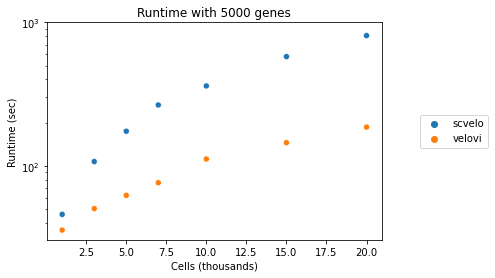

In [12]:
res_df['n_obs_thousand'] = res_df['n_obs'].astype(int) // 1e3
res_df['runtime'] = res_df['runtime'].astype(float)

fig, ax = plt.subplots(figsize=(6, 4))

with mplscience.style_context():
    sns.scatterplot(x='n_obs_thousand', y='runtime', hue='method', data=res_df, ax=ax)

ax.set_xlabel('Cells (thousands)')
ax.set_ylabel('Runtime (sec)')
ax.set_yscale('log')
ax.set_ylim((0, 1e3))
ax.set_title('Runtime with 5000 genes')
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
# plt.show()
plt.savefig('figures/retina_runtime.svg', bbox_inches='tight', format="svg")